In [1]:
# standard python modules
import numpy as np;import time;import copy

# plotting utilities
import matplotlib.pyplot as plt;import matplotlib as mpl;import matplotlib.cm as cm;import matplotlib.colors as colors
%matplotlib inline

cmap = mpl.cm.inferno

import scipy.interpolate as interpolate;import subprocess;from astropy.io import fits

# exptool imports
#from exptool.basis import eof;from exptool.basis import spheresl;from exptool.basis import *

#from ssl import *;from exptool.io import psp_io

mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['axes.linewidth'] = 1.2
mpl.rcParams['xtick.major.width'] = 1.2
mpl.rcParams['xtick.minor.width'] = 0.5
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.major.width'] = 1.2
mpl.rcParams['ytick.minor.width'] = 0.5
mpl.rcParams['ytick.minor.visible'] = True


# follow along here

# http://docs.astropy.org/en/stable/generated/examples/coordinates/plot_galactocentric-frame.html#sphx-glr-generated-examples-coordinates-plot-galactocentric-frame-py

import astropy.coordinates as coord
import astropy.units as u

# ipython reload capabilities for edits to external code
%load_ext autoreload
%autoreload 2

def jorge_galactic(x0,y0,z0,u0,v0,w0):
    
    rad = np.sqrt(x0**2+y0**2+z0**2)
    xphi= np.arctan2(y0,x0)
    xth = np.arccos(z0/rad)
    
    xur = np.zeros([3,x0.size])
    xur[0]= np.sin(xth)*np.cos(xphi)
    xur[1]= np.sin(xth)*np.sin(xphi)
    xur[2]= np.cos(xth)
         
    xuth = np.zeros([3,x0.size])
    xuth[0]= np.cos(xth)*np.cos(xphi)
    xuth[1]= np.cos(xth)*np.sin(xphi)
    xuth[2]=-np.sin(xth)

    xuphi = np.zeros([3,x0.size])
    xuphi[0]=-np.sin(xphi)
    xuphi[1]=+np.cos(xphi)
    xuphi[2]= 0.
    
    vr =    u0*  xur[0] + v0*  xur[1] + w0*  xur[2]
    vth=    u0* xuth[0] + v0* xuth[1] + w0* xuth[2]
    vphi=   u0*xuphi[0] + v0*xuphi[1] + w0*xuphi[2]
          
    vb= -vth
    
    # following the astropy conversion
    vl= vphi
         
    dk  =4.74057           #conversion from km/s
    par =1./rad             #arc sec --> rad in [kpc]
    dmul=vl / dk * par
    dmub=vb / dk * par

    f=np.pi/180.
    dB=np.arcsin(z0/rad)/f
    #dL=np.arctan(y0/x0)/f
    
    #dL[(y0<0)&(x0>0.)] += 360.
    #dL[(y0>0)&(x0<0.)] += 180.
    #dL[(y0<0)&(x0<0.)] += 180.
    
    dL = np.arctan2(y0,x0)/f
    
    #print(dL)
    
    if dL.size>1:
        dL[np.array(dL)<0.] += 360.
    else:
        if dL<0.: dL+=360.
    #if ((y0<0)&(x0>0.)): dL=dL+360.
    #if ((y0>0)&(x0<0.)): dL=dL+180.
    #if ((y0<0)&(x0<0.)): dL=dL+180.
    
    return dL,dB,rad,vr,dmul,dmub


#dLj,dBj,radj,vrj,dmulj,dmubj = jorge_galactic(np.array(KGiant.x),np.array(KGiant.y),np.array(KGiant.z),\
#                               np.array(KGiant.vx),np.array(KGiant.vy),np.array(KGiant.vz))






# set the coordinates for transformation

# use the schonrich 2010 peculiar motions
usun = 11.1
vsun = 12.24
wsun = 7.25

# use the circular velocity from ...
vcirc = 235.

# the value of mcmillan 2017
vcirc = 232.

# use the gravity 2018 result for the galactic center distance
rsun = 8.3 # in kpc

# use the sun's height above the midplane from Bovy...
zsun = 30 # in pc

v_sun = coord.CartesianDifferential([usun, vsun+vcirc, wsun]*u.km/u.s)
gc_frame = coord.Galactocentric(galcen_distance=rsun*u.kpc,
                                galcen_v_sun=v_sun,
                                z_sun=zsun*u.pc)




#http://docs.astropy.org/en/stable/generated/examples/coordinates/plot_sgr-coordinate-frame.html

from astropy.coordinates import frame_transform_graph
from astropy.coordinates.matrix_utilities import rotation_matrix, matrix_product, matrix_transpose
import astropy.coordinates as coord
import astropy.units as u

class Sagittarius(coord.BaseCoordinateFrame):
    """
    A Heliocentric spherical coordinate system defined by the orbit
    of the Sagittarius dwarf galaxy, as described in
        http://adsabs.harvard.edu/abs/2003ApJ...599.1082M
    and further explained in
        http://www.stsci.edu/~dlaw/Sgr/.

    Parameters
    ----------
    representation : `BaseRepresentation` or None
        A representation object or None to have no data (or use the other keywords)
    Lambda : `Angle`, optional, must be keyword
        The longitude-like angle corresponding to Sagittarius' orbit.
    Beta : `Angle`, optional, must be keyword
        The latitude-like angle corresponding to Sagittarius' orbit.
    distance : `Quantity`, optional, must be keyword
        The Distance for this object along the line-of-sight.
    pm_Lambda_cosBeta : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion along the stream in ``Lambda`` (including the
        ``cos(Beta)`` factor) for this object (``pm_Beta`` must also be given).
    pm_Beta : :class:`~astropy.units.Quantity`, optional, must be keyword
        The proper motion in Declination for this object (``pm_ra_cosdec`` must
        also be given).
    radial_velocity : :class:`~astropy.units.Quantity`, optional, must be keyword
        The radial velocity of this object.

    """

    default_representation = coord.SphericalRepresentation
    default_differential = coord.SphericalCosLatDifferential

    frame_specific_representation_info = {
        coord.SphericalRepresentation: [
            coord.RepresentationMapping('lon', 'Lambda'),
            coord.RepresentationMapping('lat', 'Beta'),
            coord.RepresentationMapping('distance', 'distance')]
    }
    
    

SGR_PHI = (180 + 3.75) * u.degree # Euler angles (from Law & Majewski 2010)
SGR_THETA = (90 - 13.46) * u.degree
SGR_PSI = (180 + 14.111534) * u.degree


# Generate the rotation matrix using the x-convention (see Goldstein)
D = rotation_matrix(SGR_PHI, "z")
C = rotation_matrix(SGR_THETA, "x")
B = rotation_matrix(SGR_PSI, "z")
A = np.diag([1.,1.,-1.])
SGR_MATRIX = matrix_product(A, B, C, D)

@frame_transform_graph.transform(coord.StaticMatrixTransform, coord.Galactic, Sagittarius)
def galactic_to_sgr():
    """ Compute the transformation matrix from Galactic spherical to
        heliocentric Sgr coordinates.
    """
    return SGR_MATRIX

@frame_transform_graph.transform(coord.StaticMatrixTransform, Sagittarius, coord.Galactic)
def sgr_to_galactic():
    """ Compute the transformation matrix from heliocentric Sgr coordinates to
        spherical Galactic.
    """
    return matrix_transpose(SGR_MATRIX)





In [2]:
# generate a sphere of stars

def gen_sphere_surface(npoints,cartesian=True):
    """generate evenly spaced points on the surface of a sphere
    
    inputs
    -------------
    npoints    : integer
        the maximum number of points to generate on the surface of the sphere
    cartesian  : boolean, default True
        if true, return (x,y,z). If false, return (phi,theta)
    
    note that npoints is the maximum, because we are enforcing
    equal spacing: not all npoints values return even spacing.
    
    returns
    -------------
    x,y,z      : arrays, npoints long
        cartesian location of points on the unit sphere
    phi,theta  : arrays, npoints long
        surface of sphere points in radians
    
    
    """
    npoint = 0
    points = np.zeros([npoints,3])
    sphpoints = np.zeros([npoints,2])
    
    a = 4*np.pi/npoints
    d = np.sqrt(a)
    Mtheta = np.floor(np.pi/d).astype('int')
    dtheta = np.pi/Mtheta
    dphi   = a/dtheta
    
    for m in range(0,Mtheta):
        
        theta = np.pi*(m+0.5)/Mtheta
        Mphi  = np.floor(2*np.pi*np.sin(theta)/dphi).astype('int')
        
        for n in range(0,Mphi):
            phi = 2*np.pi*n/Mphi
            points[npoint] = np.array([np.sin(theta)*np.cos(phi),
                                       np.sin(theta)*np.sin(phi),
                                       np.cos(theta)])
            sphpoints[npoint] = np.array([phi,theta])
            npoint += 1
            
    if cartesian:
        return points[:npoint,0],points[:npoint,1],points[:npoint,2]
    else:
        return sphpoints[:npoint,0],sphpoints[:npoint,1]
            


def sky_hist_2d(x,y,xbins,ybins,weights=None,sky=True):
    """easy 2d histogram for the surface of a sphere (aka the sky)"""
    
    
    X,Y = np.meshgrid(ravals,decvals)
    
    if weights is None:
        weights = np.ones(x.size)
        
        
    
    dx = np.abs(xbins[1]-xbins[0])
    dy = np.abs(ybins[1]-ybins[0])
    img = np.zeros([xbins.size,ybins.size])
    #Nxindx = (np.floor((x - np.nanmin(xbins))/(dx))).astype('int')
    #Nyindx = (np.floor((y - np.nanmin(ybins))/(dy))).astype('int')
    Nxindx = (np.round((x - np.nanmin(xbins))/(dx))).astype('int')
    Nyindx = (np.round((y - np.nanmin(ybins))/(dy))).astype('int')


    for xval in range(0,xbins.size):
        for yval in range(0,ybins.size):
            w = np.where((Nxindx==xval) & (Nyindx==yval))[0]
            if len(w) > 0:
                img[xval,yval] += np.nansum(weights[w])#/(np.cos(yval*np.pi/180.))#*np.cos(yval*np.pi/180.))

    if sky:
        return X,Y,img.T/np.cos(Y*np.pi/180.)
    else:
        return X,Y,img.T
    #return X,Y,np.cos(Y*np.pi/180.)






In [3]:
# see https://gea.esac.esa.int/archive/documentation/GDR2/Data_processing/chap_cu3ast/sec_cu3ast_intro/ssec_cu3ast_intro_tansforms.html
def return_gaia_Ag():
    """set the Hipparcos computation

    if truly obsessed see https://www.cosmos.esa.int/documents/532822/552851/vol1_all.pdf

    though this has higher precision!!
    """
    return np.array([[-0.0548755604162154,+0.4941094278755837,-0.8676661490190047],
                     [-0.8734370902348850,-0.4448296299600112,-0.1980763734312015],
                     [-0.4838350155487132,+0.7469822444972189,+0.4559837761750669]])

    

def return_gaia_Agprime():
    """return the matrix in eq 3.61, key to transform from ICRS to galactic coordinates"""
    return np.array([[-0.0548755604162154,-0.8734370902348850,-0.4838350155487132],
                     [+0.4941094278755837,-0.4448296299600112,+0.7469822444972189],
                     [-0.8676661490190047,-0.1980763734312015,+0.4559837761750669]])

def return_ricrs(a,d):
    """ eq. 3.57"""
    return np.array([np.cos(a)*np.cos(d),np.sin(a)*np.cos(d),np.sin(d)])

def return_picrs(a,d):
    """ eq. 3.64, unit vector of increasing alpha"""
    if hasattr(a,'size'):
        return np.array([-np.sin(a),np.cos(a),np.zeros(a.size)])
    else:
        return np.array([-np.sin(a),np.cos(a),0.])

def return_qicrs(a,d):
    """ eq. 3.64, unit vector of increasing delta"""
    return np.array([-np.cos(a)*np.sin(d),-np.sin(a)*np.sin(d),np.cos(d)])

def return_muicrs(a,d,mua,mud):
    """ eq. 3.66, the proper motion vector"""
    p = return_picrs(a,d)
    q = return_qicrs(a,d)
    return p*mua + q*mud



def return_rgal(l,b):
    """ eq. 3.58"""
    return np.array([np.cos(l)*np.cos(b),np.sin(l)*np.cos(b),np.sin(b)])

def return_pgal(l,b):
    """ eq. 3.66, unit vector of increasing alpha"""
    if hasattr(l,'size'):
        return np.array([-np.sin(l),np.cos(l),0.*np.cos(l)])
    else:
        return np.array([-np.sin(l),np.cos(l),0.*np.cos(l)])

def return_qgal(l,b):
    """ eq. 3.66, unit vector of increasing delta"""
    return np.array([-np.cos(l)*np.sin(b),-np.sin(l)*np.sin(b),np.cos(b)])

def return_mugal(l,b,mul,mub):
    """ eq. 3.66, the proper motion vector"""
    p = return_pgal(l,b)
    q = return_qgal(l,b)
    return p*mul + q*mub


def rotate_velocities(a,d,mua,mud):
    """eq 3.68, """
    mu = return_muicrs(a,d,mua,mud)
    mugal = np.dot(return_gaia_Agprime(),mu) # eq. 3.68
    
    # solve for positions
    ricrs = return_ricrs(a,d)
    rgal = np.dot(return_gaia_Agprime(),ricrs)

    # implement eq 3.63
    ell,b = np.arctan2(rgal[1],rgal[0]),np.arctan2(rgal[2],np.sqrt(rgal[0]*rgal[0]+rgal[1]*rgal[1]))
    
    p = return_pgal(ell,b)
    q = return_qgal(ell,b)
    
    mul = np.sum(p*mugal,axis=0)
    mub = np.sum(q*mugal,axis=0)
    #print(mul,mub)
    return mul,mub






def rotate_positions(a,d,dist):
    """eq 3.68, but built for speed"""
    # solve for positions
    if a.size>1:
        ricrs = return_ricrs(a,d)
        rgal = np.dot(return_gaia_Agprime(),ricrs)
        cpos = dist*rgal        
    else:
        ricrs = return_ricrs(a,d)
        rgal = np.dot(return_gaia_Agprime(),ricrs)
        cpos = np.dot(dist,rgal)        
    return cpos

def rotate_galactic(a,d):
    """eq 3.68, """
    mu = return_muicrs(a,d,mua,mud)
    mugal = np.dot(return_gaia_Agprime(),mu) # eq. 3.68
    
    # solve for positions
    ricrs = return_ricrs(a,d)
    rgal = np.dot(return_gaia_Agprime(),ricrs)

    # implement eq 3.63
    ell,b = np.arctan2(rgal[1],rgal[0]),np.arctan2(rgal[2],np.sqrt(rgal[0]*rgal[0]+rgal[1]*rgal[1]))

    return ell,b


def rotate_observed(l,b):
    """eq 3.68, THIS DOES NOT WORK FOR b=90 (exactly)!"""
    # solve for positions
    rgal = return_rgal(l,b)
    ricrs = np.dot(return_gaia_Ag(),rgal)
    #d = np.arcsin(ricrs[2])
    #a = np.arccos(ricrs[0]/np.cos(d))
    #print(a,d)

    # implement eq 3.63
    a,d = np.arctan2(ricrs[1],ricrs[0]),np.arctan2(ricrs[2],np.sqrt(ricrs[0]*ricrs[0]+ricrs[1]*ricrs[1]))

    return a,d


def rotate_velocities_observed(l,b,mul,mub):
    """eq 3.68, """
    mu = return_mugal(l,b,mul,mub)
    muicrs = np.dot(return_gaia_Ag(),mu) # eq. 3.68
    
    rgal = return_rgal(l,b)
    ricrs = np.dot(return_gaia_Ag(),rgal)
    a,d = np.arctan2(ricrs[1],ricrs[0]),np.arctan2(ricrs[2],np.sqrt(ricrs[0]*ricrs[0]+ricrs[1]*ricrs[1]))
    
    p = return_picrs(a,d)
    q = return_qicrs(a,d)
    
    mua = np.sum(p*muicrs,axis=0)
    mud = np.sum(q*muicrs,axis=0)
    #print(mul,mub)
    return mua,mud


a = 70.*np.pi/180.
d = 89.99*np.pi/180.
mua = -10.
mud = 1.

#print(return_muicrs(a,d,mua,mud))


print(a,d)
print(mua,mud)
print(rotate_velocities(a,d,mua,mud))
l,b = rotate_galactic(a,d)
mul,mub = rotate_velocities(a,d,mua,mud)
#print(rotate_galactic(a,d))
print(rotate_velocities_observed(l,b,mul,mub))
print(rotate_observed(l,b))


#cov_to = rotate_errors(a,d,1,2.,0.)
#print(cov_to)


#print(ricrs,rgal,ell,b)

def rotate_errors(a,d,pmra_e,pmdec_e,pmcorr):
    ricrs = return_ricrs(a,d)
    picrs = return_picrs(a,d)
    qicrs = return_qicrs(a,d)

    rgal = np.dot(return_gaia_Agprime(),ricrs)

    # implement eq 3.63
    ell = np.arctan2(rgal[1],rgal[0])
    b = np.arctan2(rgal[2],np.sqrt(rgal[0]*rgal[0]+rgal[1]*rgal[1]))

    pgal = return_pgal(ell,b)
    qgal = return_qgal(ell,b)

    pqgal = np.stack((pgal, qgal), axis=-1)
    pqicrs = np.stack((picrs, qicrs), axis=-1)
    
    cov = np.array([[pmra_e*pmra_e,pmra_e*pmdec_e*pmcorr],[pmra_e*pmdec_e*pmcorr,pmdec_e*pmdec_e]])

    #print(pqgal)
    
    #print(np.einsum('ji,ik->jk', return_gaia_Agprime(), pqicrs.astype('float')))
    
    G = np.einsum('ab,ac->bc', pqgal,
                      np.einsum('ji,ik->jk', return_gaia_Agprime(), pqicrs.astype('float')))

    cov_to = np.einsum('ba,ac->bc', G,
                           np.einsum('ij,ki->jk', cov, G))
    
    return cov_to



def haversine(lon1, lat1, lon2, lat2,deg=True):
    """
    Calculate the great circle distance between two points 
    on a sphere (specified in decimal degrees or radians)
    """
    # convert decimal degrees to radians 
    if deg:
        lon1, lat1, lon2, lat2 = (np.pi/180.)*lon1, (np.pi/180.)*lat1, (np.pi/180.)*lon2, (np.pi/180.)*lat2

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2. * np.arcsin(np.sqrt(a)) 
    if deg:
        return (180./np.pi)*c
    else:
        return c



def define_transformation_matrix(C1,C2,D1,D2,start=0):
    """define a rotation matrix to go from ICRS to arbitrary rotation
    
    takes two points on the sphere and returns the transformation that 
    puts the points along the latitude=0 plane
    
    default will produce ICRS->GAL?
    
    inputs
    ------------
    C1      :
        the azimuthal coordinate of the first point
    C2      :
        the polar coordinate of the first point
    D1      :
        the azimuthal coordinate of the second point
    D2      :
        the polar coordinate of the second point
    start   : 
        the final rotation angle defining (0,0)
    
    returns
    ------------
    A       : 3x3 array
        the transformation array, such that r' = Ar transforms r->r'
    
    
    """
    # find the pole from the defined plane
    rC    = [np.cos(C1)*np.cos(C2),np.sin(C1)*np.cos(C2),np.sin(C2)]
    rD    = [np.cos(D1)*np.cos(D2),np.sin(D1)*np.cos(D2),np.sin(D2)]
    CD    = np.cross(rC,rD)
    pole1 = np.arctan2(CD[1],CD[0])
    pole2 = np.arctan2(CD[2],np.sqrt(CD[0]*CD[0]+CD[1]*CD[1]))
    
    # see Gaia convention
    phi   = start*np.pi/180.
    theta = (90.-(180./np.pi)*pole2)*np.pi/180.
    psi   = ((180./np.pi)*pole1+90.)*np.pi/180.
    
    # see Wolfram convention
    D     = np.array([[np.cos(phi),np.sin(phi),0],[-np.sin(phi),np.cos(phi),0],[0,0,1]])
    C     = np.array([[1,0,0],[0,np.cos(theta),np.sin(theta)],[0,-np.sin(theta),np.cos(theta)]])
    B     = np.array([[np.cos(psi),np.sin(psi),0],[-np.sin(psi),np.cos(psi),0],[0,0,1]])

    A     = np.dot(D,np.dot(C,B))
    
    return A

def define_transformation_matrix_pole(pole1,pole2,start=0):
    """define a rotation matrix to go from ICRS to arbitrary rotation
    
    takes two points on the sphere and returns the transformation that 
    puts the points along the latitude=0 plane
    
    default will produce ICRS->GAL?
    
    inputs
    ------------
    pole1      :
        the azimuthal coordinate of the first point
    pole2      :
        the polar coordinate of the first point
    start   : 
        the final rotation angle defining (0,0)
    
    returns
    ------------
    A       : 3x3 array
        the transformation array, such that r' = Ar transforms r->r'
    
    
    """

    # see Gaia convention
    phi   = start*np.pi/180.
    theta = (90.-(180./np.pi)*pole2)*np.pi/180.
    psi   = ((180./np.pi)*pole1+90.)*np.pi/180.
    
    # see Wolfram convention
    D     = np.array([[np.cos(phi),np.sin(phi),0],[-np.sin(phi),np.cos(phi),0],[0,0,1]])
    C     = np.array([[1,0,0],[0,np.cos(theta),np.sin(theta)],[0,-np.sin(theta),np.cos(theta)]])
    B     = np.array([[np.cos(psi),np.sin(psi),0],[-np.sin(psi),np.cos(psi),0],[0,0,1]])

    A     = np.dot(D,np.dot(C,B))
    
    return A
    
def define_transformation_matrix_angles(phi,theta,psi=0.):
    """define a rotation matrix to go from ICRS to arbitrary rotation
    
    takes two points on the sphere and returns the transformation that 
    puts the points along the latitude=0 plane
    
    default will produce ICRS->GAL?
    
    inputs
    ------------
    phi     : first, rotation around z axis
    theta   : second, rotation around x axis
    psi     : third, rotation around (new) z axis
    
    returns
    ------------
    A       : 3x3 array
        the transformation array, such that r' = Ar transforms r->r'
    
    
    """
    # see Gaia convention
    #phi   = start*np.pi/180.
    #theta = (90.-(180./np.pi)*pole2)*np.pi/180.
    #psi   = ((180./np.pi)*pole1+90.)*np.pi/180.
    
    # see Wolfram convention
    D     = np.array([[np.cos(phi),np.sin(phi),0],[-np.sin(phi),np.cos(phi),0],[0,0,1]])
    #C     = np.array([[1,0,0],[0,np.cos(theta),np.sin(theta)],[0,-np.sin(theta),np.cos(theta)]])
    C     = np.array([[np.cos(theta),0,-np.sin(theta)],[0,1,0],[np.sin(theta),0,np.cos(theta)]])

    B     = np.array([[np.cos(psi),np.sin(psi),0],[-np.sin(psi),np.cos(psi),0],[0,0,1]])

    A     = np.dot(D,np.dot(C,B))
    
    return A

def rotate_arbitrary(a,d,Aprime):
    """eq 3.68, """
    #mu = return_muicrs(a,d,mua,mud)
    #mugal = np.dot(return_gaia_Agprime(),mu) # eq. 3.68
    
    # solve for positions
    ricrs = return_ricrs(a,d)
    rgal = np.dot(Aprime,ricrs)

    # implement eq 3.63
    ell,b = np.arctan2(rgal[1],rgal[0]),np.arctan2(rgal[2],np.sqrt(rgal[0]*rgal[0]+rgal[1]*rgal[1]))

    return ell,b


def rotate_velocities_arbitrary(a,d,mua,mud,Aprime):
    """eq 3.68, """
    mu = return_muicrs(a,d,mua,mud)
    mugal = np.dot(Aprime,mu) # eq. 3.68
    
    # solve for positions
    ricrs = return_ricrs(a,d)
    rgal = np.dot(Aprime,ricrs)

    # implement eq 3.63
    ell,b = np.arctan2(rgal[1],rgal[0]),np.arctan2(rgal[2],np.sqrt(rgal[0]*rgal[0]+rgal[1]*rgal[1]))
    
    p = return_pgal(ell,b)
    q = return_qgal(ell,b)
    
    mul = np.sum(p*mugal,axis=0)
    mub = np.sum(q*mugal,axis=0)
    #print(mul,mub)
    return mul,mub






1.2217304763960306 1.570621793869697
-10.0 1.0
(-6.266399187466095, -7.856986777596376)
(array([-10.]), 0.9999999999910104)
(1.2217304763951318, 1.570621793869697)


2.9932396671702732 1.439896632895322


[]

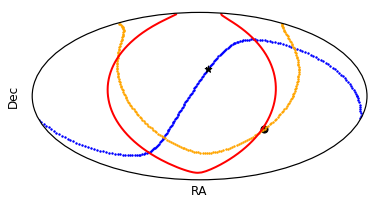

In [4]:

def define_points_at_angle(angular_separation,phi0,theta0,resolution=200,manlam=[0]):
    """define a set of points at fixed angular distance from a specified spherical surface point
    
    inputs
    ---------
    angular_separation : (degrees)
    phi0
    theta0
    
    requires
    ---------
    define_transformation_matrix_angles
    
    """
    phi = angular_separation*np.pi/180.
    lam = np.linspace(0.,2*np.pi,resolution)
    if len(manlam)>1:
        lam = manlam
    phip = np.pi/2. - phi
    cvals = [np.sin(phip),np.cos(phip)*np.cos(lam),np.cos(phip)*np.sin(lam)]
    x1,x2 = np.arctan2(cvals[1],cvals[0]),np.arctan2(cvals[2],np.sqrt(cvals[0]*cvals[0]+cvals[1]*cvals[1]))
    Bprime = define_transformation_matrix_angles(phi0*np.pi/180.,theta0*np.pi/180.,0.)
    x1b,x2b = rotate_arbitrary(x1,x2,Bprime)
    return x1b,x2b



lmcl,lmcb = -79,-32.75
x1,x2 = define_points_at_angle(90.,0.,0.,resolution=200)
x1,x2 = define_points_at_angle(90.,188.5,-7.5,manlam=np.linspace(-1.5*np.pi,0.48*np.pi,200))

x1b,x2b = define_points_at_angle(90.,lmcl,lmcb,resolution=200)

indx = 80
x1d,x2d = define_points_at_angle(90.,-x1b[indx]*180./np.pi,x2b[indx]*180./np.pi,resolution=200)
print(x1[0],x2[0])



ax = plt.subplot(111, projection="aitoff")
ax.plot(x1,x2,color='red')
ax.scatter(x1b,x2b,color='blue',s=2.)
#ax.scatter(x1c,x2c,color='green',s=2.)
ax.scatter(-lmcl*np.pi/180.,lmcb*np.pi/180.,color='black',s=50.)

ax.scatter(x1d,x2d,color='orange',s=2.)
ax.scatter(x1b[indx],x2b[indx],color='black',s=50.,marker='*')




ax.set_xlabel('RA',size=12)
ax.set_ylabel('Dec',size=12)
ax.set_xticklabels(())
ax.set_yticklabels(())

In [40]:
L = define_transformation_matrix_pole(188.5*np.pi/180.,-7.5*np.pi/180.,start=-45)
print(L)
LMC.pm_lt,LMC.pm_bt = rotate_velocities_arbitrary(LMC.phi,LMC.th,LMC.pm_l,LMC.pm_b,L)
LMC.phi_t,LMC.th_t = rotate_arbitrary(LMC.phi,LMC.th,L)
MW.pm_lt,MW.pm_bt = rotate_velocities_arbitrary(MW.phi,MW.th,MW.pm_l,MW.pm_b,L)
MW.phi_t,MW.th_t = rotate_arbitrary(MW.phi,MW.th,L)

# also for Galactocentric. However, we might want a different rotation?
LMCg.pm_lt,LMCg.pm_bt = rotate_velocities_arbitrary(LMCg.phi,LMCg.th,LMCg.pm_l,LMCg.pm_b,L)
LMCg.phi_t,LMCg.th_t = rotate_arbitrary(LMCg.phi,LMCg.th,L)
MWg.pm_lt,MWg.pm_bt = rotate_velocities_arbitrary(MWg.phi,MWg.th,MWg.pm_l,MWg.pm_b,L)
MWg.phi_t,MWg.th_t = rotate_arbitrary(MWg.phi,MWg.th,L)

[[ 0.1957992  -0.68569761 -0.70105738]
 [ 0.01323487 -0.71298203  0.70105738]
 [-0.9805547  -0.14654488 -0.13052619]]


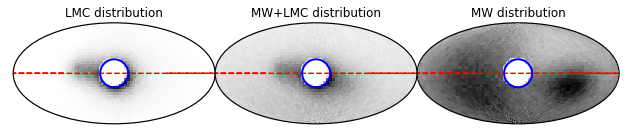

In [35]:
galactic_l = np.concatenate([MW.phi_t,LMC.phi_t])
galactic_b = np.concatenate([MW.th_t,LMC.th_t])
distance = np.concatenate([MW.r,LMC.r])
mass = np.concatenate([MW.mass,LMC.mass])
lmc = np.concatenate([np.zeros(MW.r.size),np.ones(LMC.r.size)])

#X,Y = np.meshgrid(ravals,decvals)
ddeg = 5.
ravals = np.arange(-180,180,ddeg)+ddeg/2.
decvals = np.arange(-90,90,ddeg)+ddeg/2.


msdist = haversine(galactic_l*180./np.pi,galactic_b*180./np.pi,0,0,deg=True)
mindist,maxdist = 30.,75.
mstol = 25.



# LMC only
criteria = (lmc==1)&(distance>mindist)&(distance<maxdist)&(msdist>mstol)
X,Y,img_ZLr = sky_hist_2d(galactic_l[criteria]*180./np.pi,galactic_b[criteria]*180./np.pi,\
                        ravals,decvals,weights=mass[criteria])

# MW only
criteria = (lmc==0)&(distance>mindist)&(distance<300.)&(msdist>mstol)
X,Y,img_ZMr = sky_hist_2d(galactic_l[criteria]*180./np.pi,galactic_b[criteria]*180./np.pi,\
                        ravals,decvals,weights=mass[criteria])

# combined
criteria = (distance>mindist)&(distance<maxdist)&(msdist>mstol)
X,Y,img_ZNr = sky_hist_2d(galactic_l[criteria]*180./np.pi,galactic_b[criteria]*180./np.pi,\
                        ravals,decvals,weights=mass[criteria])




fig = plt.figure(figsize=(8.5,1.8))
ax1 = fig.add_axes([0.005,0.05,0.33,0.8], projection="aitoff")
ax2 = fig.add_axes([0.335,0.05,0.33,0.8], projection="aitoff")
ax3 = fig.add_axes([0.665,0.05,0.33,0.8], projection="aitoff")


#plt.pcolormesh(X*np.pi/180.,Y*np.pi/180.,np.log10(img_Z),cmap=cm.Greys)
ax1.pcolormesh(-X*np.pi/180.,Y*np.pi/180.,img_ZLr/np.nanmean(img_ZLr),cmap=cm.Greys)
ax2.pcolormesh(-X*np.pi/180.,Y*np.pi/180.,img_ZNr/np.nanmean(img_ZNr),cmap=cm.Greys)
ax3.pcolormesh(-X*np.pi/180.,Y*np.pi/180.,img_ZMr/np.nanmean(img_ZMr),cmap=cm.Greys)


x1b,x2b = define_points_at_angle(25.,0.,0.,resolution=200)

# Magellanic Stream system
# with an override to prevent looping
x1,x2 = define_points_at_angle(90.,0,-90,manlam=np.linspace(-1.*np.pi,0.0,200))




for ax in [ax1,ax2,ax3]:
    ax.plot(x1b,x2b,color='blue',zorder=10)
    ax.plot(x1,x2,color='red',linestyle='dashed',lw=1.5)
    


ax1.set_title('LMC distribution',size=12)
ax2.set_title('MW+LMC distribution',size=12)
ax3.set_title('MW distribution',size=12)



for ax in [ax1,ax2,ax3]:
    ax.set_xticklabels(())
    ax.set_yticklabels(())


plt.savefig('figures/predictedLMClocation_rotated.png',dpi=300)

In [37]:
LMCa = 81.28 * np.pi/180.
LMCd = -69.78 * np.pi/180.
LMCl,LMCb = rotate_galactic(LMCa,LMCd)
tmp1,tmp2 = rotate_velocities(LMCa,LMCd,1.7608,0.308)

PW1 = np.genfromtxt('pw1_catalog_clean.csv',skip_header=1)
H3 = np.genfromtxt('h3_stream.csv',skip_header=1)

sfac = np.pi/180.
pw1_mul,pw1_mub = rotate_velocities(sfac*PW1[:,0],sfac*PW1[:,1],PW1[:,8],PW1[:,10])
pw1_l,pw1_b = rotate_galactic(sfac*PW1[:,0],sfac*PW1[:,1])

h3_mul,h3_mub = rotate_velocities(sfac*H3[:,0],sfac*H3[:,1],H3[:,8],H3[:,10])
h3_l,h3_b = rotate_galactic(sfac*H3[:,0],sfac*H3[:,1])

L = define_transformation_matrix_pole(188.5*np.pi/180.,-7.5*np.pi/180.,start=-45)
#L = define_transformation_matrix_pole(188.5*np.pi/180.,-7.5*np.pi/180.,start=0)

#print(PW1[:,0],PW1[:,1])
a,b = rotate_arbitrary(pw1_l,pw1_b,L)
print((180./np.pi)*a,(180./np.pi)*b)

# pick a couple of points for v_b
x1 = [(180./np.pi)*LMCb,-10,10,(180./np.pi)*pw1_b[0]]
x2 = [49.5*4.74*tmp2,200.,200.,pw1_mub[0]]
p = np.polyfit(x1,x2,1)
v_b_fit = np.poly1d(p)

# pick a couple of points for v_l
x1 = [(180./np.pi)*LMCb,-10,10,(180./np.pi)*pw1_b[0]]
x2 = [49.5*4.74*tmp1,-150.,-100,-75]
print(x1)
p = np.polyfit(x1,x2,2)
v_l_fit = np.poly1d(p)


# pick a couple of points for mu_b
x1 = [(180./np.pi)*LMCb,-10,10,(180./np.pi)*pw1_b[0]]
x2 = [tmp2,1.5,0.6,pw1_mub[0]]
p = np.polyfit(x1,x2,1)
mu_b_fit = np.poly1d(p)

# pick a couple of points for mu_l
x1 = [(180./np.pi)*LMCb,-10,0,10,(180./np.pi)*pw1_b[0]]
x2 = [tmp1,-0.7,-0.7,-0.7,pw1_mul[0]]
print(x1)
p = np.polyfit(x1,x2,2)
mu_l_fit = np.poly1d(p)

# pick a couple of points for vlos
x1 = [(180./np.pi)*LMCb,-10,0,10,(180./np.pi)*pw1_b[3]]
x2 = [262.,275,350,330,PW1[3,6]]
print(x1)
p = np.polyfit(x1,x2,2)
vlos_fit = np.poly1d(p)

lrange = np.linspace(-30,30,100)




[72.37096208 76.06572848 76.23869063 76.02741558 77.7639232  76.15306344
 76.17503134 75.96928684 77.06902993 76.23773843 76.24253011 75.52754798
 76.19882503 76.06708198 76.05558249 76.15552007 75.37759828 77.12276695
 76.17652792 77.82482726 75.93140176 76.09932819 76.2373122  76.14855404
 77.85168769] [-13.34531742 -12.61177223 -12.63846921 -12.66426018 -13.16050034
 -12.89180017 -12.79481825 -12.58243256 -12.39204987 -12.5018806
 -12.82923292 -13.69328316 -12.21731259 -12.25517626 -12.33657439
 -12.46856353 -13.11226724 -12.69940284 -12.84392584 -13.1862836
 -12.18468494 -12.29369959 -13.01203984 -12.39538948 -13.18459646]
[-32.75285101334855, -10, 10, 28.270573108503168]
[-32.75285101334855, -10, 0, 10, 28.270573108503168]
[-32.75285101334855, -10, 0, 10, 31.817940199190573]


## Bring in extra data

In [10]:
PW1 = np.genfromtxt('pw1_catalog.csv',skip_header=1)
H3 = np.genfromtxt('h3_stream.csv',skip_header=1)

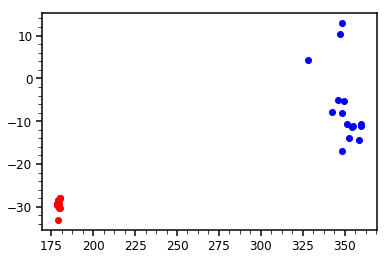

In [11]:
plt.scatter(PW1[:,0],PW1[:,1],color='red')
plt.scatter(H3[:,0],H3[:,1],color='blue')

31924
1.010997443925478
1.010997443925478


Text(0, 0.5, 'galactic b')

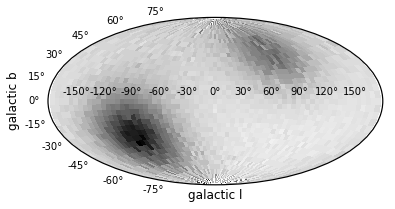

In [44]:
ddeg = 5.
ravals = np.arange(-180,180,ddeg)+ddeg/2.
decvals = np.arange(-90,90,ddeg)+ddeg/2.

criteria = (lmc==1)&(distance<60.)&(distance>40.)#&(netpm>.5)&(netpm<1.0)
criteria = (distance<60.)&(distance>40.)#&(netpm>.5)&(netpm<1.0)


xpos,ypos,zpos = gen_sphere_surface(32000)
print(xpos.size)

a = 0.*(np.pi/180.)
b = 40*(np.pi/180.)
c = -80.*(np.pi/180.)
cosa = np.cos(a);sina = np.sin(a)
cosb = np.cos(b);sinb = np.sin(b)
cosc = np.cos(c);sinc = np.sin(c)

eulermat = np.array([[cosa*cosb*cosc - sina*sinc,-cosc*sina - cosa*cosb*sinc,cosa*sinb],
                     [sina*cosb*cosc + cosa*sinc, cosa*cosc - cosb*sina*sinc,sina*sinb],
                     [               - sinb*cosc,                  sinb*sinc, cosb]])


tiltpts = np.dot(np.array([xpos*1.5,ypos,zpos]).T,eulermat)
xpos,ypos,zpos = tiltpts[:,0],tiltpts[:,1],tiltpts[:,2]

print(np.nanmax(xpos))
xsun = 8./40.
ypos -= xsun
print(np.nanmax(xpos))
lvals = np.arctan2(ypos,xpos)
bvals = np.arctan2(zpos,np.sqrt(xpos*xpos+ypos*ypos))


X,Y,img_Z = sky_hist_2d(lvals*180./np.pi,bvals*180./np.pi,ravals,decvals)




#X,Y = np.meshgrid(ravals,decvals)
ddeg = 5.
ravals = np.arange(-180,180,ddeg)+ddeg/2.
decvals = np.arange(-90,90,ddeg)+ddeg/2.

X,Y,img_Z = sky_hist_2d(lvals*180./np.pi,bvals*180./np.pi,ravals,decvals)


plt.subplot(111, projection="aitoff")
#plt.pcolormesh(X*np.pi/180.,Y*np.pi/180.,np.log10(img_Z),cmap=cm.Greys)
plt.pcolormesh(X*np.pi/180.,Y*np.pi/180.,img_Z/np.nanmean(img_Z),cmap=cm.Greys)


#plt.pcolormesh(X*np.pi/180.,Y*np.pi/180.,np.log10(img_Z),cmap=cm.Greys)

#plt.pcolormesh(X*np.pi/180.,Y*np.pi/180.,1./np.cos(Y*np.pi/180.),cmap=cm.Greys,vmin=0.5,vmax=1.5)


#plt.imshow(np.log10(img_Z),origin='lower',\
#           extent=(np.nanmin(ravals),np.nanmax(ravals),np.nanmin(decvals),np.nanmax(decvals)),\
#           cmap=cm.Greys,aspect='auto')


plt.xlabel('galactic l',size=12)
plt.ylabel('galactic b',size=12)



In [97]:
2**5

32

In [9]:
from astropy.io import fits
indir = '/Volumes/External1/RRLyrae/SMASH/'
fits_image_filename = indir+'Field42_allobj.fits'
#fits_image_filename = indir+'Field109_allobj.fits'
#fits_image_filename = indir+'Field80_allobj.fits'
#fits_image_filename = indir+'Field166_allobj.fits'




hdul = fits.open(fits_image_filename)

In [10]:
#hdul[1].header

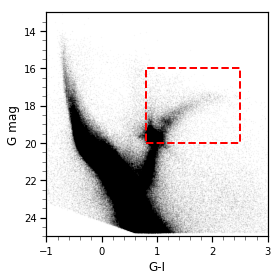

In [33]:
#smash_l,smash_b = rotate_galactic((np.pi/180.)*hdul[1].data['RA'],(np.pi/180.)*hdul[1].data['DEC'])
#print(smash_l*180./np.pi)
w = np.where((hdul[1].data['G']>0) & (hdul[1].data['G']<24.8)\
             &(hdul[1].data['I']>0) & (hdul[1].data['I']<24.2))[0][::5]

plt.figure(figsize=(4,4))


#ugriz
clr = (hdul[1].data['G']-hdul[1].data['I'])
mag = (hdul[1].data['G'])
ra  = (hdul[1].data['RA'])
dec = (hdul[1].data['DEC'])
ids = (hdul[1].data['ID'])
plt.scatter(clr[w],mag[w],color='black',s=0.1,alpha=0.04)

plt.axis([-1,3,25,13])

# g vs g-i color selection space

plt.plot([0.8,2.5,2.5,0.8,0.8],[20.,20.,16.,16.,20.],color='red',linestyle='dashed')

plt.xlabel('G-I',size=12)
plt.ylabel('G mag',size=12)
plt.tight_layout()
plt.savefig('/Users/mpetersen/Downloads/testphotometry_LMC.png',dpi=300)
# r vs r-z color selection space
#plt.plot([0.3,2.5,2.5,0.3,0.3],[19.5,19.5,16.,16.,19.5],color='red',linestyle='dashed')



In [19]:
w = np.where((hdul[1].data['G']>0) & (hdul[1].data['G']<24.8)\
             &(hdul[1].data['I']>0) & (hdul[1].data['I']<24.2))[0]


clr = (hdul[1].data['G']-hdul[1].data['I'])
mag = (hdul[1].data['G'])
clr2 = (hdul[1].data['R']-hdul[1].data['Z'])
mag2 = (hdul[1].data['R'])
ra  = (hdul[1].data['RA'])
dec = (hdul[1].data['DEC'])
ids = (hdul[1].data['ID'])

fnum = '42a'

f = open(indir+'src_field{}.csv'.format(fnum),'w')

print('name,ra,dec,mag,clr',file=f)

for indx in w:
    if (clr[indx]>0.75) & (clr[indx]<2.5) & (mag[indx]<20) & (mag[indx]>15) &\
    (clr2[indx]>0.3) & (clr2[indx]<2.5) & (mag2[indx]<19.5) & (mag2[indx]>15):
        print('{},{},{},{},{}'.format(ids[indx],ra[indx],dec[indx],mag[indx],clr[indx]),file=f)

f.close()

In [20]:
A = np.genfromtxt(indir+'src_field109.csv',delimiter=',')
A = np.genfromtxt(indir+'src_field42.csv',delimiter=',')
#A = np.genfromtxt(indir+'src_field80.csv',delimiter=',')
#A = np.genfromtxt(indir+'src_field166.csv',delimiter=',')



print(A[:,0].size)

A = np.genfromtxt(indir+'src_field42a.csv',delimiter=',')
#A = np.genfromtxt(indir+'src_field80.csv',delimiter=',')
#A = np.genfromtxt(indir+'src_field166.csv',delimiter=',')



print(A[:,0].size)

158913
157004


[-1, 3, 25, 13]

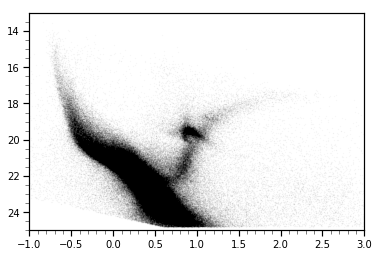

In [141]:
w = np.where((hdul[1].data['G']>0) & (hdul[1].data['G']<24.8)\
             &(hdul[1].data['I']>0) & (hdul[1].data['I']<24.2))[0][::10]

plt.scatter((hdul[1].data['G']-hdul[1].data['I'])[w],(hdul[1].data['G'])[w],color='black',s=0.1,alpha=0.04)

plt.axis([-1,3,25,13])




In [ ]:
plt.plot([0.75,2.5,2.5,0.75,0.75],[20.,20.,16.,16.,20.],color='red',linestyle='dashed')

In [23]:
# now look at the cross-matching with EDR3

def read_gaia(infile):
    f = open(infile,'r')


    headertmp = f.readline().split(',')
    header = [head.strip('\n') for head in headertmp]
    #print(header)

    RRL = {}
    for head in header: RRL[head] = []

    stringvals = ['name','phot_variable_flag','source_id']

    for line in f:
        splitline = line.split(',')
        #print(splitline)
        for ih,head in enumerate(header):

            if head in stringvals:
                RRL[head].append(splitline[ih].strip('\n'))

            else:
                try:
                    RRL[head].append(float(splitline[ih].strip('\n')))
                except:
                    RRL[head].append(np.nan)

    for head in header: 
        RRL[head] = np.array(RRL[head])

    return RRL



In [34]:
#S109 = read_gaia(indir+'smash109-result.csv')
S109 = read_gaia(indir+'smash80-result.csv')
#S109 = read_gaia(indir+'smash166-result.csv')
#S109 = read_gaia(indir+'smash42-result.csv')


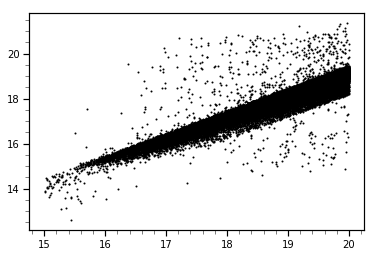

In [35]:
plt.scatter(S109['sgmag'],S109['phot_g_mean_mag'],color='black',s=1.)

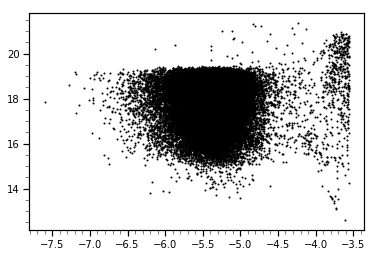

In [36]:
plt.scatter(np.log10(S109['dist']),S109['phot_g_mean_mag'],color='black',s=1.)

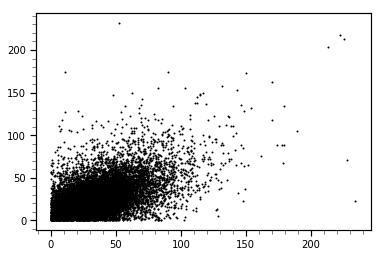

In [37]:
#plt.scatter(np.log10(S109['dist']),S109['phot_g_mean_mag'],color='black',s=1.)

pmrasig = np.abs(S109['pmra'])/S109['pmra_error']
pmdecsig = np.abs(S109['pmdec'])/S109['pmdec_error']
parallaxsig = np.abs(S109['parallax'])/S109['parallax_error']

w = np.where((parallaxsig<3.) & (pmrasig>3.) & (pmdecsig>3.)& (S109['ruwe']<1.4))
w = np.where((parallaxsig<3.) & (S109['ruwe']<1.4) & (np.log10(S109['dist'])<-4.25))

plt.scatter(pmrasig[w],pmdecsig[w],color='black',s=1.)
#plt.axis([0.,20.,0.,20.])


[20.65781711 20.56895616 20.58343343 ... 20.15843022 20.16326439
 20.12108217]


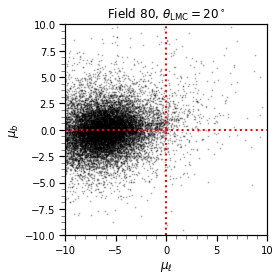

In [42]:
plt.figure(figsize=(4,4))


smash_l,smash_b = rotate_galactic((np.pi/180.)*S109['ra'],(np.pi/180.)*S109['dec'])
smash_pml,smash_pmb = rotate_velocities((np.pi/180.)*S109['ra'],(np.pi/180.)*S109['dec'],S109['pmra'],S109['pmdec'])
#plt.scatter((180./np.pi)*smash_l,(180./np.pi)*smash_b,color='black',s=1.)
plt.scatter(smash_pml[w],smash_pmb[w],color='black',s=1.,alpha=0.2)

lmcl,lmcb = -79,-32.75
msdist = haversine((180./np.pi)*smash_l,(180./np.pi)*smash_b,lmcl,lmcb,deg=True)

print(msdist)


plt.axis([-10.,10.,-10.,10.])
plt.plot([0,0],[-10.,10.],color='red',linestyle='dotted')
plt.plot([-10.,10.],[0,0],color='red',linestyle='dotted')

plt.title('Field 80, $\\theta_{\\rm LMC}=$20$^\circ$',size=12)
plt.xlabel('$\mu_\ell$',size=12)
plt.ylabel('$\mu_b$',size=12)
plt.tight_layout()
plt.savefig('figures/test_propermotion_field80.png',dpi=300)
